In [1]:
# 1. Imports

import os
import sys
import joblib
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath(".."))
import pandas as pd
import numpy as np

from src.preprocessing import load_data, split_data, scale_features
from src.error_analysis import print_classification_report, plot_confusion_matrix, get_misclassified_samples
from src.interpretability import plot_logistic_coefficients, plot_shap_summary, plot_shap_waterfall

In [2]:
# 2. Load the Best Model (Logistic Regression)

model_path = os.path.join('..', 'models', 'best_model.pkl')
best_model = joblib.load(model_path)
print("Best model loaded successfully!")

Best model loaded successfully!


In [3]:
# 3. Load and Prepare the Data

df = load_data('../data/raw/Data for Task 1.csv')

# Split the data
X_train, X_test, y_train, y_test = split_data(df)

# Apply standard scaling as in the best performing model
X_train_scaled, X_test_scaled = scale_features(X_train, X_test, method='standard')

# Get feature names
feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f"feature_{i}" for i in range(X_train_scaled.shape[1])]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



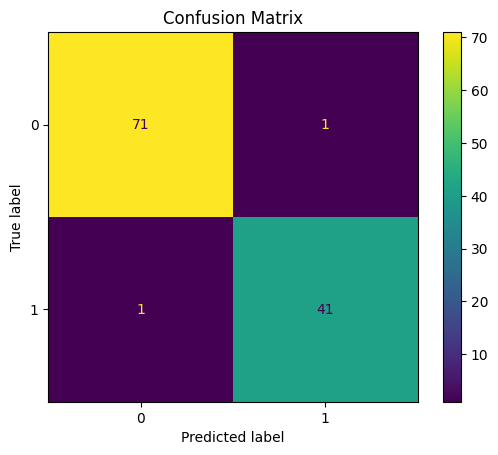

Number of misclassified samples: 2


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,true_label,predicted_label
Sample Index,,,,,,,,,,,,,,,,,,,,,
36,-0.195490,0.532703,-0.240695,-0.262128,-1.061183,-0.836864,-0.724140,-0.739393,-0.094905,-1.000116,...,-0.148201,-0.168115,-1.019973,-0.334054,-0.319237,-0.065961,0.149883,-0.702680,1,0
41,0.098594,1.322462,0.156813,0.006217,-0.579768,0.317986,0.130819,-0.265361,0.227867,0.062157,...,0.175016,-0.131710,0.070269,1.001159,0.583814,0.072905,0.460379,0.984078,0,1


In [4]:
# 4. Error Analysis

# Print a detailed classification report
print_classification_report(best_model, X_test_scaled, y_test)

# Plot and display the confusion matrix; the figure is also saved to disk
plot_confusion_matrix(best_model, X_test_scaled, y_test, save_path='../reports/figures/confusion_matrix_error_analysis.png')

# Retrieve misclassified samples for further inspection
misclassified_df = get_misclassified_samples(best_model, X_test_scaled, y_test)
misclassified_df = misclassified_df.reset_index().rename(columns={'index': 'Sample Index'}).set_index('Sample Index')
print("Number of misclassified samples:", len(misclassified_df))
display(misclassified_df.head())  # display the first few misclassified samples

In [5]:
# 5. Get predictions and prediction probabilities
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Sample Index': range(len(y_test)),
    'Actual Diagnosis': ['Malignant' if y == 1 else 'Benign' for y in y_test],
    'Predicted Diagnosis': ['Malignant' if y == 1 else 'Benign' for y in y_pred],
    'Confidence (%)': np.max(y_pred_proba, axis=1) * 100,
    'Correct Prediction': y_test == y_pred
}).set_index('Sample Index')  # Set Sample Index as the index to avoid the unnamed column

# Sort by confidence score
results_df = results_df.sort_values('Confidence (%)', ascending=False)

# Format confidence scores to 2 decimal places
results_df['Confidence (%)'] = results_df['Confidence (%)'].round(2)

# Display the results
pd.set_option('display.max_rows', None)  # Show all rows
print("\nPrediction Results:")
print("=" * 80)
print("Note: Use the index number to generate SHAP waterfall plots for specific samples")
print("Example: plot_shap_waterfall(shap_values, X_test_scaled, feature_names, instance_index=<index>)")
print("=" * 80)
display(results_df)

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 80)
print(f"Total Samples: {len(results_df)}")
print(f"Correct Predictions: {results_df['Correct Prediction'].sum()}")
print(f"Incorrect Predictions: {len(results_df) - results_df['Correct Prediction'].sum()}")
print(f"Average Confidence: {results_df['Confidence (%)'].mean():.2f}%")
print(f"Average Confidence (Correct Predictions): {results_df[results_df['Correct Prediction']]['Confidence (%)'].mean():.2f}%")
print(f"Average Confidence (Incorrect Predictions): {results_df[~results_df['Correct Prediction']]['Confidence (%)'].mean():.2f}%")

# Reset display options
pd.reset_option('display.max_rows')



Prediction Results:
Note: Use the index number to generate SHAP waterfall plots for specific samples
Example: plot_shap_waterfall(shap_values, X_test_scaled, feature_names, instance_index=<index>)


,Actual Diagnosis,Predicted Diagnosis,Confidence (%),Correct Prediction
Sample Index,,,,
106,Malignant,Malignant,100.00,True
65,Malignant,Malignant,100.00,True
6,Malignant,Malignant,100.00,True
52,Malignant,Malignant,100.00,True
7,Malignant,Malignant,100.00,True
24,Malignant,Malignant,100.00,True
3,Malignant,Malignant,100.00,True
39,Malignant,Malignant,99.99,True
62,Malignant,Malignant,99.98,True



Summary Statistics:
Total Samples: 114
Correct Predictions: 112
Incorrect Predictions: 2
Average Confidence: 95.11%
Average Confidence (Correct Predictions): 95.45%
Average Confidence (Incorrect Predictions): 75.80%


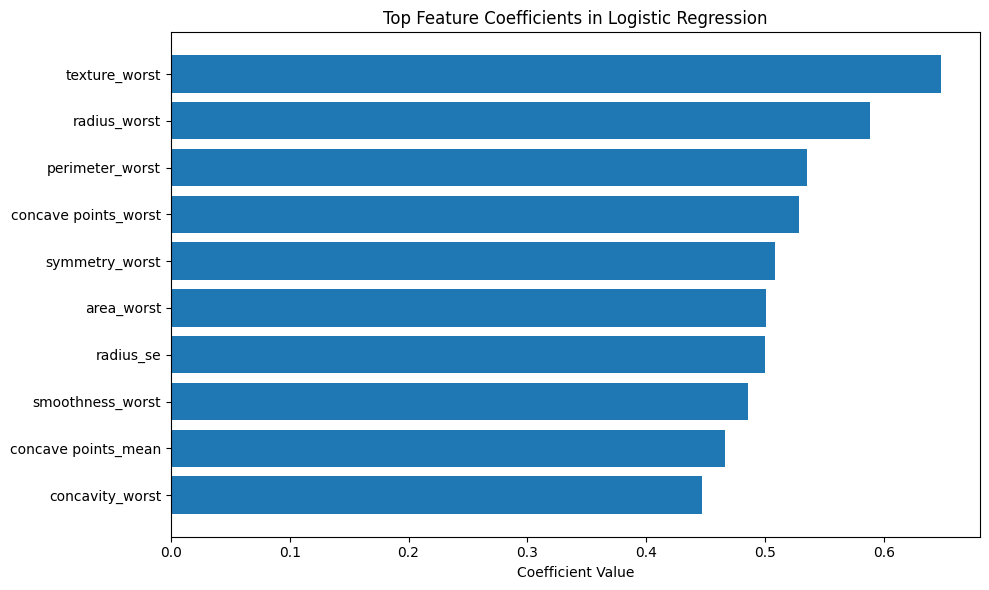

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


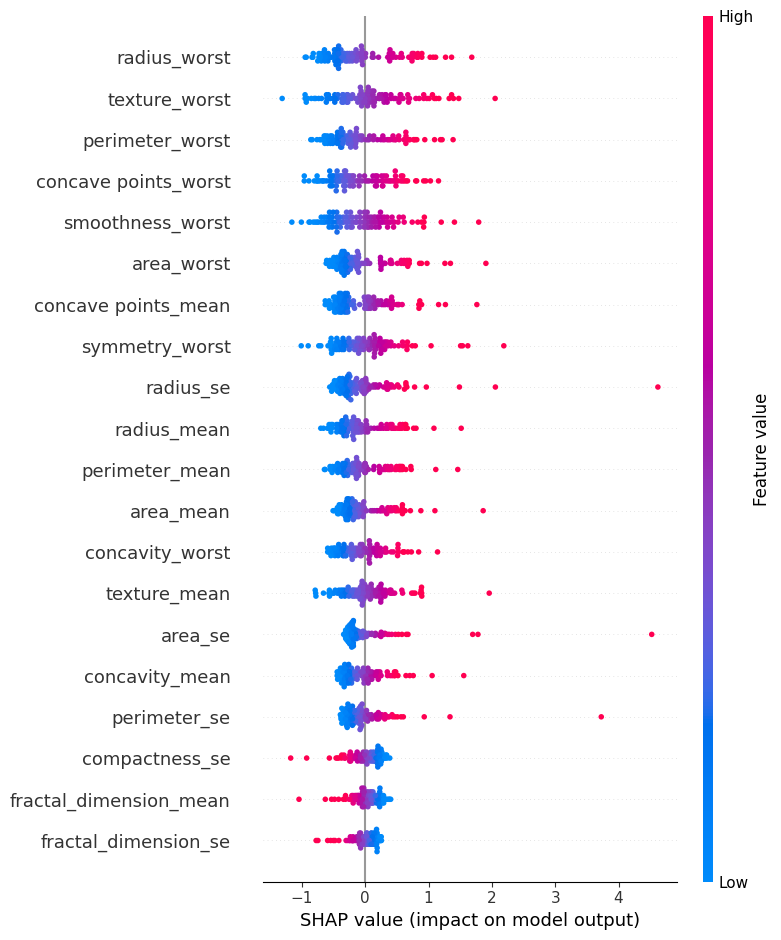

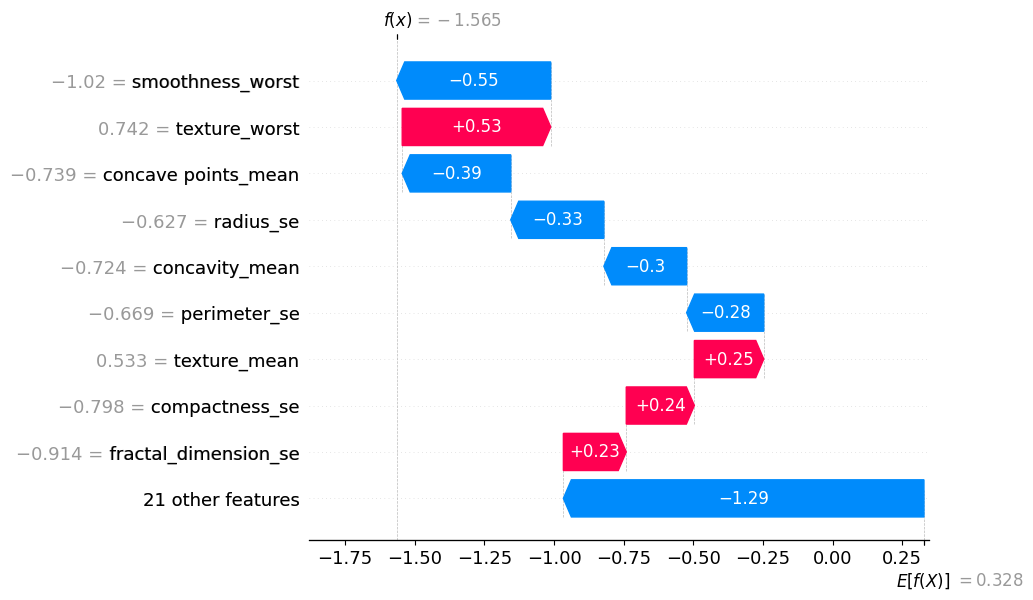

In [6]:
# 6. Interpretability Analysis

# Plot the top 10 logistic regression coefficients
plot_logistic_coefficients(best_model, feature_names, top_n=10, save_path='../reports/figures/logistic_coefficients.png')

# Run the SHAP summary plot
shap_values = plot_shap_summary(best_model, X_train_scaled, X_test_scaled, feature_names, save_path='../reports/figures/shap_summary.png')

# Run the SHAP waterfall plot
plot_shap_waterfall(shap_values, X_test_scaled, feature_names, instance_index=36, save_path='../reports/figures/shap_waterfall.png')